In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as pdr
from ta.volatility import BollingerBands
import datetime as dt
import talib

import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')

In [152]:
ticker='enph'
start_date = '2023-01-12'
end_date = '2023-06-04'

ticker_df = yf.download(ticker, start=start_date, end=end_date)
tickerData = yf.Ticker(ticker)
# Get the historical prices for this ticker
df = tickerData.history(period='120d', interval='1D')


ticker_df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-26,165.660004,166.880005,161.850006,165.199997,165.199997,2686300
2023-05-30,167.720001,175.809998,167.300003,174.119995,174.119995,4056600
2023-05-31,173.850006,176.220001,169.300003,173.880005,173.880005,3659000
2023-06-01,174.250000,184.059998,172.300003,181.470001,181.470001,3087200
2023-06-02,187.869995,187.990005,179.729996,181.860001,181.860001,3046600


In [153]:
rolling_mean = ticker_df['Close'].rolling(window=20).mean()
rolling_std = ticker_df['Close'].rolling(window=20).std()

rolling_std.sum()

1003.4555118793392

In [154]:
#BBands calculation
upper_band= rolling_mean + 2 * rolling_std
lower_band = rolling_mean - 2 * rolling_std

upper_band.tail()

Date
2023-05-26    169.848589
2023-05-30    172.199660
2023-05-31    173.427769
2023-06-01    176.868819
2023-06-02    179.573796
Name: Close, dtype: float64

In [155]:
bb_width = (upper_band - lower_band) / rolling_mean * 100
bb_width.tail()

Date
2023-05-26     9.971524
2023-05-30    11.991532
2023-05-31    12.132385
2023-06-01    14.631649
2023-06-02    16.180117
Name: Close, dtype: float64

In [156]:
print("Bollinger Bands and Bollinger Bands Width", start_date, "to", end_date) 
'' ''
print("Upper Bollinger Band:") 
print(upper_band.tail().mean()) 
''
print("Lower Bollinger Band:") 
print(lower_band.tail().mean())
''
print("Bollinger Band Width:") 
print(bb_width.tail().mean())

Bollinger Bands and Bollinger Bands Width 2023-01-12 to 2023-06-04
Upper Bollinger Band:
174.38372676923802
Lower Bollinger Band:
153.0944711677737
Bollinger Band Width:
12.981441231649953


<AxesSubplot: xlabel='Date'>

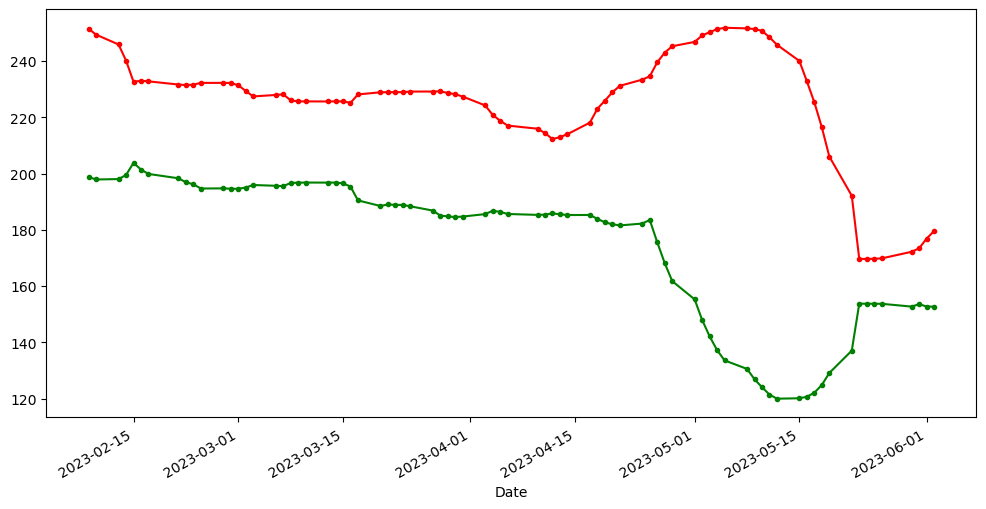

In [157]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
upper_band.plot(ax=ax, color='red', marker='o', markersize=3, label='Upper BBand')
lower_band.plot(ax=ax, color='green', marker='o', markersize=3, label='Lower BBand')

In [158]:
m = 2

ticker_df['MA'] = ticker_df['Close'].rolling(window=20).mean()
ticker_df['ATR'] = ticker_df['High'] - ticker_df['Low']
ticker_df['Upper'] = ticker_df['MA'] + m * ticker_df['ATR'].rolling(window=20).mean()
ticker_df['Lower'] = ticker_df['MA'] + m * ticker_df['ATR'].rolling(window=20).mean()

In [159]:
# Calculate Bollinger Bands
upper, middle, lower = talib.BBANDS(ticker_df['Close'], timeperiod=20)

In [160]:
# Add Bollinger Bands to data frame
ticker_df['Upper_BB'] = upper
ticker_df['Middle_BB'] = middle
ticker_df['Lower_BB'] = lower

In [161]:
ticker_df['EMA'] = talib.EMA(ticker_df['Close'], timeperiod=20)

ticker_df['ATR'] = talib.ATR(ticker_df['High'], ticker_df['Low'], ticker_df['Close'], timeperiod=20)

ticker_df['Keltner_Upper'] = ticker_df['EMA'] + 2 * ticker_df['ATR']
ticker_df['Keltner_Lower'] = ticker_df['EMA'] - 2 * ticker_df['ATR']


<AxesSubplot: xlabel='Date'>

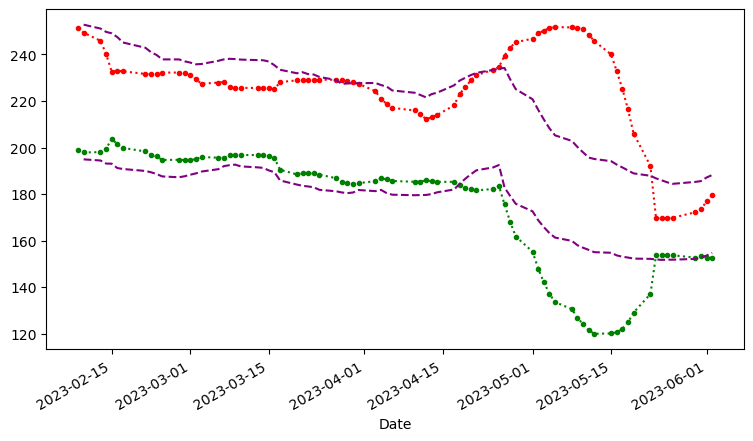

In [162]:
#import seaborn as sns
fig, ax = plt.subplots(figsize=(9,5))
upper_band.plot(ax=ax, color='red', linestyle=':', marker='o', markersize=3, label='Upper_BB')
lower_band.plot(ax=ax, color='green', linestyle=':', marker='o', markersize=3, label='Lower_BB')

ticker_df['Keltner_Upper'].plot(ax=ax, color='purple', linestyle='--', label='Upper Keltner')
ticker_df['Keltner_Lower'].plot(ax=ax, color='purple', linestyle='--', label='Lower Keltner')
#ticker_df['ATR'].plot(ax=ax, color='blue', label='ATR')


In [163]:
## Identify where the Keltner Channel drops under the Bollinger Bands
ticker_df['Keltner_BBand_Cross'] = ((ticker_df['Keltner_Upper'] < ticker_df['Upper_BB']) | 
                                    (ticker_df['Keltner_Lower'] > ticker_df['Lower_BB']))

ticker_df['Cross_Signal'] = np.where(ticker_df['Keltner_BBand_Cross'], -1, 0)


In [164]:
ticker_df = ticker_df.drop(columns=['Adj Close'])
ticker_df.tail()

,Open,High,Low,Close,Volume,MA,ATR,Upper,Lower,Upper_BB,Middle_BB,Lower_BB,EMA,Keltner_Upper,Keltner_Lower,Keltner_BBand_Cross,Cross_Signal
Date,,,,,,,,,,,,,,,,,
2023-05-26,165.660004,166.880005,161.850006,165.199997,2686300,161.782499,8.147408,173.167501,173.167501,169.644351,161.782499,153.920647,168.128752,184.423567,151.833937,False,0
2023-05-30,167.720001,175.809998,167.300003,174.119995,4056600,162.458999,8.270537,174.001000,174.001000,171.953021,162.458999,152.964977,168.699346,185.240421,152.158272,False,0
2023-05-31,173.850006,176.220001,169.300003,173.880005,3659000,163.508999,8.203010,175.069999,175.069999,173.176621,163.508999,153.841377,169.192742,185.598763,152.786722,False,0
2023-06-01,174.250000,184.059998,172.300003,181.470001,3087200,164.811499,8.380859,176.948499,176.948499,176.563521,164.811499,153.059477,170.362005,187.123724,153.600286,True,-1
2023-06-02,187.869995,187.990005,179.729996,181.860001,3046600,166.133499,8.374817,178.571500,178.571500,179.233480,166.133499,153.033518,171.457052,188.206686,154.707418,True,-1


In [165]:
ticker_df['Cross_Signal'].unique()

array([ 0, -1])

In [166]:
ticker_df.tail(14)

,Open,High,Low,Close,Volume,MA,ATR,Upper,Lower,Upper_BB,Middle_BB,Lower_BB,EMA,Keltner_Upper,Keltner_Lower,Keltner_BBand_Cross,Cross_Signal
Date,,,,,,,,,,,,,,,,,
2023-05-15,167.710007,172.110001,165.589996,168.710007,3397400,180.074999,9.835525,195.203004,195.203004,238.487830,180.074999,121.662169,174.466797,194.137847,154.795746,True,-1
2023-05-16,167.350006,169.000000,160.800003,160.960007,3329700,176.729500,9.753749,191.758504,191.758504,231.350865,176.729500,122.108134,173.180436,192.687933,153.672938,True,-1
2023-05-17,161.300003,165.589996,159.089996,163.729996,2930200,173.702499,9.591061,188.759503,188.759503,223.987887,173.702499,123.417112,172.280394,191.462517,153.098271,True,-1
2023-05-18,163.270004,164.570007,159.600006,163.720001,2503500,170.649000,9.360008,185.507005,185.507005,215.250215,170.649000,126.047785,171.465118,190.185135,152.745101,True,-1
2023-05-19,165.350006,166.720001,161.520004,162.369995,3103000,167.587000,9.152008,182.278003,182.278003,205.063657,167.587000,130.110342,170.598916,188.902932,152.294900,True,-1
2023-05-22,162.800003,166.949997,162.660004,164.649994,2622800,164.589499,8.923408,178.630501,178.630501,191.425826,164.589499,137.753172,170.032352,187.879167,152.185537,True,-1
2023-05-23,162.380005,166.139999,161.539993,162.830002,2664600,161.700999,8.707238,175.393002,175.393002,169.446867,161.700999,153.955130,169.346414,186.760889,151.931939,False,0
2023-05-24,160.250000,164.330002,158.809998,164.050003,2458700,161.711999,8.547876,173.686002,173.686002,169.470544,161.711999,153.953453,168.841994,185.937746,151.746242,False,0
2023-05-25,165.360001,165.369995,161.550003,164.589996,2562800,161.732499,8.311482,173.413502,173.413502,169.519136,161.732499,153.945862,168.437042,185.060005,151.814078,False,0


In [167]:
ticker_df.to_csv('keltnercross.csv', index=False)

In [168]:
ticker_df['RSI'] = talib.RSI(ticker_df['Close'], timeperiod=20)
ticker_df['MFI'] = talib.RSI(ticker_df['Close'])

ticker_df.tail(3)

,Open,High,Low,Close,Volume,MA,ATR,Upper,Lower,Upper_BB,Middle_BB,Lower_BB,EMA,Keltner_Upper,Keltner_Lower,Keltner_BBand_Cross,Cross_Signal,RSI,MFI
Date,,,,,,,,,,,,,,,,,,,
2023-05-31,173.850006,176.220001,169.300003,173.880005,3659000,163.508999,8.203010,175.069999,175.069999,173.176621,163.508999,153.841377,169.192742,185.598763,152.786722,False,0,47.638118,51.893040
2023-06-01,174.250000,184.059998,172.300003,181.470001,3087200,164.811499,8.380859,176.948499,176.948499,176.563521,164.811499,153.059477,170.362005,187.123724,153.600286,True,-1,52.313347,58.579365
2023-06-02,187.869995,187.990005,179.729996,181.860001,3046600,166.133499,8.374817,178.571500,178.571500,179.233480,166.133499,153.033518,171.457052,188.206686,154.707418,True,-1,52.542535,58.895503


In [169]:
xgb_model = ticker_df.drop(columns=['Open', 'High', 'Low', 'ATR'])

xgb_model.tail()

,Close,Volume,MA,Upper,Lower,Upper_BB,Middle_BB,Lower_BB,EMA,Keltner_Upper,Keltner_Lower,Keltner_BBand_Cross,Cross_Signal,RSI,MFI
Date,,,,,,,,,,,,,,,
2023-05-26,165.199997,2686300,161.782499,173.167501,173.167501,169.644351,161.782499,153.920647,168.128752,184.423567,151.833937,False,0,41.698340,42.726940
2023-05-30,174.119995,4056600,162.458999,174.001000,174.001000,171.953021,162.458999,152.964977,168.699346,185.240421,152.158272,False,0,47.778826,52.140161
2023-05-31,173.880005,3659000,163.508999,175.069999,175.069999,173.176621,163.508999,153.841377,169.192742,185.598763,152.786722,False,0,47.638118,51.893040
2023-06-01,181.470001,3087200,164.811499,176.948499,176.948499,176.563521,164.811499,153.059477,170.362005,187.123724,153.600286,True,-1,52.313347,58.579365
2023-06-02,181.860001,3046600,166.133499,178.571500,178.571500,179.233480,166.133499,153.033518,171.457052,188.206686,154.707418,True,-1,52.542535,58.895503


In [170]:
xgb_model.to_csv('xgbmodel.csv')

In [171]:
ticker_df['MACD'], _, _ = talib.MACD(ticker_df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [172]:
ticker_df = ticker_df.dropna()

In [173]:

ticker_df['Target'] = ticker_df['Close'].shift(-1)

In [174]:
#removed last row since no target
ticker_df = ticker_df[:-1]

In [175]:
#Split data into features and target

X = ticker_df.drop('Target', axis=1)
y = ticker_df['Target']

In [176]:
y.head()

Date
2023-03-02    217.160004
2023-03-03    225.350006
2023-03-06    224.210007
2023-03-07    218.309998
2023-03-08    215.850006
Name: Target, dtype: float64

In [177]:
X.head()

,Open,High,Low,Close,Volume,MA,ATR,Upper,Lower,Upper_BB,Middle_BB,Lower_BB,EMA,Keltner_Upper,Keltner_Lower,Keltner_BBand_Cross,Cross_Signal,RSI,MFI,MACD
Date,,,,,,,,,,,,,,,,,,,,
2023-03-02,209.339996,212.350006,207.440002,211.559998,1804100,212.195502,11.717977,234.068504,234.068504,228.915947,212.195502,195.475057,212.336245,235.772200,188.900291,False,0,43.330784,45.378580,-4.832439
2023-03-03,213.360001,219.179993,210.770004,217.160004,2547300,211.668502,11.552578,233.012504,233.012504,227.008441,211.668502,196.328563,212.795651,235.900807,189.690495,False,0,46.427858,49.828557,-3.926029
2023-03-06,218.570007,230.440002,217.610001,225.350006,4529600,211.789503,11.638949,233.569505,233.569505,227.516157,211.789503,196.062848,213.991304,237.269202,190.713406,False,0,50.585356,55.534161,-2.517805
2023-03-07,225.169998,227.669998,219.460007,224.210007,2938500,211.850503,11.467501,233.340505,233.340505,227.758875,211.850503,195.942131,214.964514,237.899516,192.029512,False,0,50.016628,54.603333,-1.476742
2023-03-08,222.720001,223.580002,213.660004,218.309998,3170400,211.343002,11.421626,232.770004,232.770004,225.668363,211.343002,197.017641,215.283131,238.126383,192.439879,False,0,47.129933,49.938094,-1.114921


In [178]:
# Split data into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=5)

In [179]:
#Create XGBoost Model
model = xgb.XGBRegressor(objective = 'reg:squarederror')

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [180]:
y_pred = model.predict(X_test)  
y_pred

array([212.47862, 165.22003, 223.05722, 167.48166, 195.85912, 162.65384,
       164.8483 , 206.50848, 195.0819 , 180.78546, 222.62634, 161.3912 ,
       158.93047, 159.64882, 161.33879, 223.35283], dtype=float32)

In [181]:
X_test['Predicted'] = y_pred
y_pred

array([212.47862, 165.22003, 223.05722, 167.48166, 195.85912, 162.65384,
       164.8483 , 206.50848, 195.0819 , 180.78546, 222.62634, 161.3912 ,
       158.93047, 159.64882, 161.33879, 223.35283], dtype=float32)

In [182]:
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])
y_pred_df

,Predicted
0,212.478622
1,165.220032
2,223.057220
3,167.481659
4,195.859116
5,162.653839
6,164.848297
7,206.508484
8,195.081894
9,180.785461


In [183]:
#Display feature importance
importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                feature    importance
2                   Low  3.998122e-01
18                  MFI  1.656432e-01
6                   ATR  1.578219e-01
14        Keltner_Lower  9.190792e-02
7                 Upper  5.320389e-02
0                  Open  4.114165e-02
1                  High  3.980052e-02
3                 Close  1.356696e-02
11             Lower_BB  1.328444e-02
9              Upper_BB  1.219464e-02
17                  RSI  6.334484e-03
19                 MACD  2.373017e-03
12                  EMA  9.581408e-04
4                Volume  8.193296e-04
13        Keltner_Upper  5.802933e-04
5                    MA  5.574269e-04
15  Keltner_BBand_Cross  3.644314e-08
8                 Lower  0.000000e+00
16         Cross_Signal  0.000000e+00
10            Middle_BB  0.000000e+00


In [184]:
# Create a DataFrame for predictions
y_predictdf = pd.DataFrame(y_pred, columns=['Predicted'], index=X_test.index)

# Concatenate the actual and predicted 'Close' prices
result_df = pd.concat([y_test, pred_df], axis=1)

print(result_df)

                Target   Predicted
Date                              
2023-03-07  218.309998  216.490723
2023-03-16  183.639999  205.134323
2023-03-27         NaN  202.463791
2023-03-31  202.600006         NaN
2023-04-04  193.669998  195.943695
2023-04-06         NaN  192.513489
2023-04-12  209.690002  196.201950
2023-04-13  208.899994         NaN
2023-04-17  227.869995  220.211395
2023-04-18         NaN  221.750443
2023-04-19         NaN  221.388840
2023-04-25         NaN  220.702179
2023-04-28  160.589996  164.667160
2023-05-01         NaN  165.426422
2023-05-02  155.419998  161.652863
2023-05-03  155.419998         NaN
2023-05-05         NaN  159.660965
2023-05-08  157.830002  163.378830
2023-05-16  163.729996         NaN
2023-05-22  162.830002         NaN
2023-05-23         NaN  165.255859
2023-05-26  174.119995         NaN
2023-05-30  173.880005         NaN
2023-06-01  181.860001         NaN


In [150]:
result_df = result_df.sort_index()
result_df.iloc[-10:-1]

,Target,Predicted
Date,,
2023-04-17,227.869995,220.211395
2023-04-18,224.270004,221.750443
2023-04-19,224.789993,221.388840
2023-04-25,163.830002,220.702179
2023-04-28,160.589996,164.667160
2023-05-01,152.880005,165.426422
2023-05-02,155.419998,161.652863
2023-05-05,163.289993,159.660965
2023-05-08,157.830002,163.378830


In [147]:
result_plot = result_df.hvplot.line()
result_plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [82]:
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='absolute_error')

In [83]:
gbm.fit(X_train, y_train)

GradientBoostingRegressor(loss='absolute_error', max_depth=1, random_state=42)

In [84]:
predictions = gbm.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("The MSE on test set: {:.4f}".format(mse))

The MSE on test set: 52.0965


In [ ]:
training_report = classifcation_report(y_train, predictions)
training_report